In [31]:
from __future__ import annotations as _annotations

from website_to_rag.utils.webpage_extractor import WebPage, Section

from typing import Set
from dataclasses import dataclass, field

from pydantic_graph import BaseNode, GraphRunContext, End, Graph
from pydantic_ai import Agent, RunContext
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.openai import OpenAIModel
from rich.prompt import Prompt

import ollama

from typing import Protocol

In [32]:
class Embedder(Protocol):
    def __call__(self, text: str) -> list[float]: ...

In [48]:
class OllamaEmbedder:
    def __init__(self, model_name: str):
        self.model_name = model_name

    def __call__(self, text: str) -> list[float]:
        return ollama.embeddings(prompt=text, model=self.model_name).embedding

In [49]:
K = 8

In [90]:
@dataclass
class State:
    user_query: str
    retrieval_agent_history: list[ModelMessage] = field(default_factory=set)
    unused_urls: Set[str] = field(default_factory=set)
    searched_urls: Set[str] = field(default_factory=set)
    unembedded_webpages: list[WebPage] = field(default_factory=list)
    embedded_webpages: list[tuple(WebPage, Section, list[list[float]])] = field(
        default_factory=list
    )


@dataclass
class Ask(BaseNode[State]):
    """User asks a question"""

    async def run(self, ctx: GraphRunContext[State]) -> Plan:
        ctx.state.user_query = Prompt.ask("What can I help you with?")
        return Retrieval


@dataclass
class Plan(BaseNode[State]):
    """Plan the steps to answer the user's question"""

    def run(self, ctx: GraphRunContext[State]) -> Retrieval | Evaluate: ...


@dataclass
class RetrievalResult:
    top_5_results: list[str]
    urls: list[str]


@dataclass
class NoRelevantData: ...


@dataclass
class RetrievalDeps:
    embedded_webpages: list[tuple(WebPage, Section, list[list[float]])]
    embedding_model: Embedder


def create_retrieval_agent(model: str | OpenAIModel) -> Agent:
    # ollama_model = OpenAIModel(model_name='qwen2.5:7b', base_url='http://localhost:11434/v1')
    retrieval_agent = Agent[RetrievalDeps, RetrievalResult | NoRelevantData](
        model,
        result_type=RetrievalResult | NoRelevantData,
        deps_type=RetrievalDeps,
        system_prompt=(
            "Given a user query use the `retrieval_tool` to search websites in memory for information relevant to answer the user's question. "
            "If the information recieved is not relevant to the user's query try changing the prompt you give to the retrieval tool. "
            "If there still doesn't appear to be relevant information after 2 tries return 'NoRelevantData'"
        ),
        retries=2,
    )

    @retrieval_agent.tool(retries=2)
    async def retrieval_tool(
        ctx: RunContext[RetrievalDeps], prompt: str
    ) -> list[dict[str, str]]:
        query_embedding = ctx.deps.embedding_model(prompt)

        def _metric(webpage, section, embedding) -> float:
            return section.compute_distance(query_embedding)

        top_k_results = sorted(
            ctx.deps.embedded_webpages, key=lambda x: _metric(*x), reverse=True
        )[:K]

        return top_k_results

    return retrieval_agent


@dataclass
class Retrieval(BaseNode[State]):
    """Attempt to find information related to the question"""

    def run(self, ctx: GraphRunContext[State]) -> Search | Plan:
        return Search()


@dataclass
class Search(BaseNode[State]):
    """Search for more information if necessary"""

    def run(self, ctx: GraphRunContext[State]) -> EmbedWebPages: ...


@dataclass
class EmbedWebPages(BaseNode[State]):
    """Embed new information"""

    def run(self, ctx: GraphRunContext[State]) -> Retrieval: ...


@dataclass
class SummaryResult:
    summary: str
    sources: list[str]


@dataclass
class Evaluate(BaseNode[State]):
    """Evaluate model answer"""

    def run(self, ctx: GraphRunContext[State]) -> Plan | Summerize: ...


@dataclass
class Summerize(BaseNode[State, None, SummaryResult]):
    """Summerize the answer"""

    def run(self, ctx: GraphRunContext[State]) -> Evaluate | End[SummaryResult]: ...

In [91]:
graph = Graph(
    nodes=[Ask, Plan, Retrieval, Search, EmbedWebPages, Evaluate, Summerize],
    state_type=State,
    run_end_type=SummaryResult,
)

In [92]:
from IPython.display import Image

INFO:httpx:HTTP Request: GET https://mermaid.ink/img/LS0tCnRpdGxlOiBncmFwaAotLS0Kc3RhdGVEaWFncmFtLXYyCiAgWypdIC0tPiBBc2sKICBBc2sgLS0+IFBsYW4KICBQbGFuIC0tPiBSZXRyaWV2YWwKICBQbGFuIC0tPiBFdmFsdWF0ZQogIFJldHJpZXZhbCAtLT4gU2VhcmNoCiAgUmV0cmlldmFsIC0tPiBQbGFuCiAgU2VhcmNoIC0tPiBFbWJlZFdlYlBhZ2VzCiAgRW1iZWRXZWJQYWdlcyAtLT4gUmV0cmlldmFsCiAgRXZhbHVhdGUgLS0+IFBsYW4KICBFdmFsdWF0ZSAtLT4gU3VtbWVyaXplCiAgU3VtbWVyaXplIC0tPiBFdmFsdWF0ZQogIFN1bW1lcml6ZSAtLT4gWypd "HTTP/1.1 200 OK"


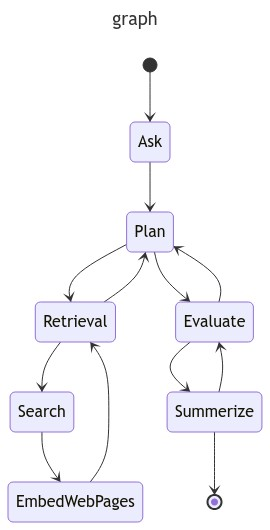

In [93]:
Image(graph.mermaid_image(start_node=Ask))

In [94]:
agent = create_retrieval_agent(
    OpenAIModel(model_name="qwen2.5:7b", base_url="http://localhost:11434/v1")
)

In [95]:
result = agent.run(
    "Where were the olympics held in 2012?",
    deps=RetrievalDeps(
        embedded_webpages=[], embedding_model=OllamaEmbedder("nomic-embed-text")
    ),
)

In [96]:
data = await result

INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


In [97]:
data.data

NoRelevantData()

In [30]:
response = ollama.embeddings(
    model="nomic-embed-text", prompt="The sky is blue because of rayleigh scattering"
)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embeddings "HTTP/1.1 200 OK"


In [29]:
response

EmbeddingsResponse(embedding=[0.5889952182769775, 0.400834858417511, -3.303218126296997, -0.525968074798584, 0.7489901781082153, 1.5185997486114502, -0.1251041144132614, 0.39591342210769653, 0.06778016686439514, -1.1088330745697021, 0.6926167011260986, 1.2775923013687134, 1.146063208580017, 1.089024543762207, 0.2504419982433319, 0.2928600311279297, 0.1518256962299347, -0.6344521045684814, -0.2100622057914734, -0.1958126723766327, -1.7958611249923706, -0.6291590332984924, 0.03886444866657257, -0.6687489748001099, 1.26125967502594, 1.2771027088165283, -0.15987950563430786, -0.0024411454796791077, -0.29727184772491455, -0.4807409644126892, 1.2050529718399048, -0.6383835077285767, -0.5400329828262329, -1.0354485511779785, 0.6314492225646973, -1.208990454673767, 0.6834062337875366, -0.058553166687488556, -0.19721460342407227, 0.12762127816677094, -0.014400124549865723, -0.5544140934944153, 0.3516940772533417, 0.04494372010231018, 0.597441554069519, -0.9552484154701233, 0.5079353451728821, 1